ANN for NARX

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from scipy.io import loadmat
import os
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, Normalizer
from sklearn.linear_model import LinearRegression

# out = loadmat(f'UnbalancedDisk-sim-data.mat')
data_dir = 'Data'
data_file = 'UnbalancedDisk-sim-data.mat'
out = loadmat(os.path.join(data_dir, data_file))
x = out['ulist'][0,:]
y = out['ylist'][0,:] 
x=x[0:5000]
y=y[0:5000]

In [64]:
na, nb = 2, 2
ulist = x
ylist = y
def make_training_data(ulist,ylist,na,nb):
    Xdata = []
    Ydata = []
    
    for k in range(max(na,nb),len(ulist)): 
        Xdata.append(np.concatenate([ulist[k-nb:k],ylist[k-na:k]])) 
        Ydata.append(ylist[k])
    return np.array(Xdata), np.array(Ydata)

Xdata, Ydata = make_training_data(ulist,ylist, na, nb)

from sklearn.model_selection import train_test_split 
Xtrain, Xval, Ytrain, Yval = train_test_split(Xdata, Ydata) 

In [65]:
class Network(nn.Module):
    def __init__(self, n_in=4, n_neurons=64,activation='relu'):
        super(Network,self).__init__()
        self.lay1 = nn.Linear(n_in,n_neurons).double()
#         self.lay1a = nn.Linear(n_neurons,n_neurons).double()
        self.lay2 = nn.Linear(n_neurons,1).double()
    
    def forward(self,u):
        if activation=='relu':
            x1 = torch.relu(self.lay1(u))
        elif activation=='sigmoid':
            x1 = torch.sigmoid(self.lay1(u))
        elif activation=='tanh':
            x1 = torch.tanh(self.lay1(u))
        y = self.lay2(x1)[:,0] 
        return y

In [66]:
X_data=torch.from_numpy(Xtrain)
Y_data=torch.from_numpy(Ytrain)
X_val=torch.from_numpy(Xval)
Y_val=torch.from_numpy(Yval)

In [67]:
n_neurons_list = [8, 16, 32, 64,128] #, 128]
n_neurons = 64
# lr = 5e-4
lr = 1e-3
# lr_list = [1e-4, 5e-4, 1e-3,5e-3]
# activation_list = ['relu', 'sigmoid', 'tanh']
activation = 'relu'
Loss_hist = []
Loss_sigmoid = []
Loss_hist_test = []
for n_neurons in n_neurons_list:
# for activation in activation_list:
# for lr in lr_list:
    model = Network(n_neurons=n_neurons, activation=activation)
#     print(model)
    parameters = list(model.parameters())
#     print(parameters) 
#     Loss_hist = []
    optimizer = torch.optim.Adam(model.parameters(),lr=lr) 
    for epoch in range(10000):
        Loss = torch.mean((model(X_data)-Y_data)**2)
        Loss_test = torch.mean((model(X_val)-Y_val)**2)
        Loss_hist.append(Loss)
        Loss_hist_test.append(Loss_test)
        optimizer.zero_grad()
        Loss.backward() 
        optimizer.step() 
    #     if epoch%1000==0: 
    #        print(f'epoch={epoch} Loss={Loss}')
    test_loss = torch.mean((model(X_val)-Y_val)**2)
    print(f'Lr = {lr} N_neurons = {n_neurons} Train loss = {Loss} Test loss = {test_loss}')

Lr = 0.001 N_neurons = 64 Train loss = 1.4605044038022142e-05 Test loss = 2.541747013299106e-05
Lr = 0.001 N_neurons = 64 Train loss = 2.2968153292522814e-05 Test loss = 2.9044011112573144e-05
Lr = 0.001 N_neurons = 64 Train loss = 1.016635230031405e-05 Test loss = 2.455476549237721e-05


In [60]:
activation

'sigmoid'

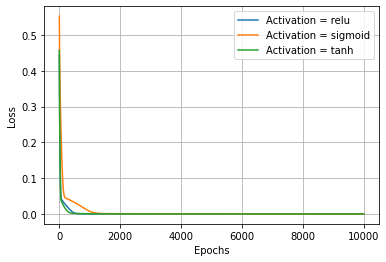

In [68]:
with torch.no_grad():
    epoch = range(0,9999)
    for i in range(0,3):
        if i == 3:
            z_order = 1
#             l_width = 1.5
        else: 
            z_order = 2
#             l_width = 1.5
        plt.plot(epoch,Loss_hist[i*10000:(i+1)*10000-1], label=f'Activation = {activation_list[i]}', zorder = z_order) #, linewidth=l_width)
    plt.legend()
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('Loss_hist_activation')
    plt.show()

In [12]:
lr_list[2]

0.001

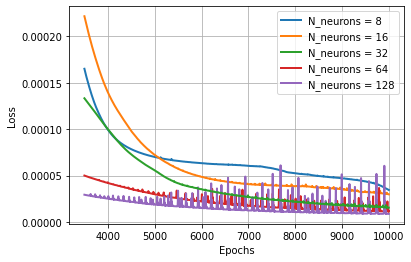

In [54]:
with torch.no_grad():
    epoch = range(3500,9999)
    for i in range(0,5):
        if i != 2: 
            z_order = 2
        else: 
            z_order = 3
        plt.plot(epoch,Loss_hist[i*10000+3500:(i+1)*10000-1], label=f'N_neurons = {n_neurons_list[i]}', zorder=z_order,linewidth=2)
#         plt.plot(epoch,Loss_hist_test[i*10000+5000:(i+1)*10000-1],'--', label=f'N_neurons test = {n_neurons_list[i]}', zorder=z_order,linewidth=2)
    plt.legend()
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('Loss_hist_n_neurons_end')
    plt.show()

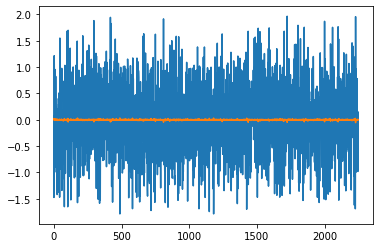

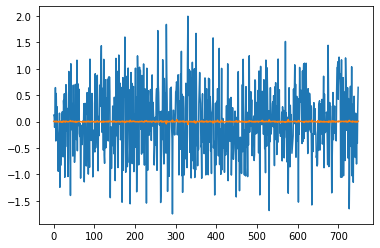

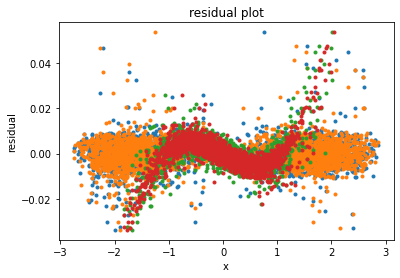

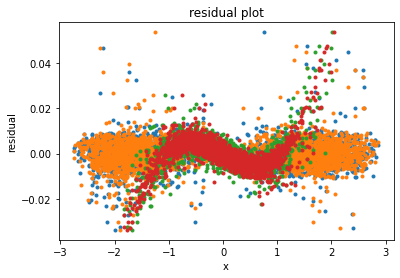

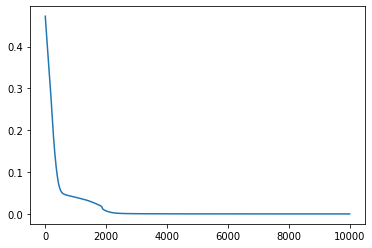

In [29]:
with torch.no_grad():
    plt.plot(model(X_data),label='predicted')
    plt.plot(model(X_data)-Y_data,label='error')  
    plt.show()

    plt.plot(model(X_val),label='predicted')
    plt.plot(model(X_val)-Y_val,label='error')     
    plt.show()

    plt.title('residual plot')
    plt.xlabel('x')
    plt.ylabel('residual')
    plt.plot(X_data,Y_data-model(X_data),'.')
    plt.show()

    plt.title('residual plot')
    plt.xlabel('x')
    plt.ylabel('residual')
    plt.plot(X_data,Y_data-model(X_data),'.')
    plt.show()
    
    plt.plot(Loss_hist)
    plt.show


In [25]:
res = Y_data-model(X_data)

In [26]:
res.shape

torch.Size([2248])

In [27]:
X_data.shape

torch.Size([2248, 4])